# Final Year Project 
#### Members :
* Saptarshi Dhibar - 10200118026
* Sanchita Pandit - 10200118027
* Niladri Sarker - 10200118037
* Koustav Roy - 10200118038

# **Fake Job Detection**
The `Employment Scam Aegean Dataset `(EMSCAD) is a dataset containing 17,880 `real-life job` ads that aims at providing a clear picture of the `Employment Scam problem`.


---



---



## Dataset Description
* Name - Description
* Title	- The title of the job ad entry.
* Location	- Geographical location of the job ad.
* Department	- Corporate department (e.g. sales).
* Salary range	- Indicative salary range (e.g. $50,000-$60,000)
* Company profile -	A brief company description.
* Description	- The details description of the job ad.
* Requirements -	Enlisted requirements for the job opening.
* Benefits	- Enlisted offered benefits by the employer.
* Telecommuting -	True for telecommuting positions.
* Company logo -	True if company logo is present.
* Questions -	True if screening questions are present.
* Fraudulent -	Classification attribute.
In balanced	Selected for the balanced dataset
* Employment type -	Full-type, Part-time, Contract, etc.
* Required experience	- Executive, Entry level, Intern, etc.
* Required education -	Doctorate, Master’s Degree, Bachelor, etc.
* Industry	- Automotive, IT, Health care, Real estate, etc.
* Function -	Consulting, Engineering, Research, Sales etc.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [3]:
df = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")

In [4]:
del df['salary_range']
del df['job_id']

In [5]:
df.fillna(" ",inplace = True)

In [6]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function'] 

In [7]:
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']

In [8]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [9]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)      

In [11]:
df.text = df.text.apply(lemmatize_words)

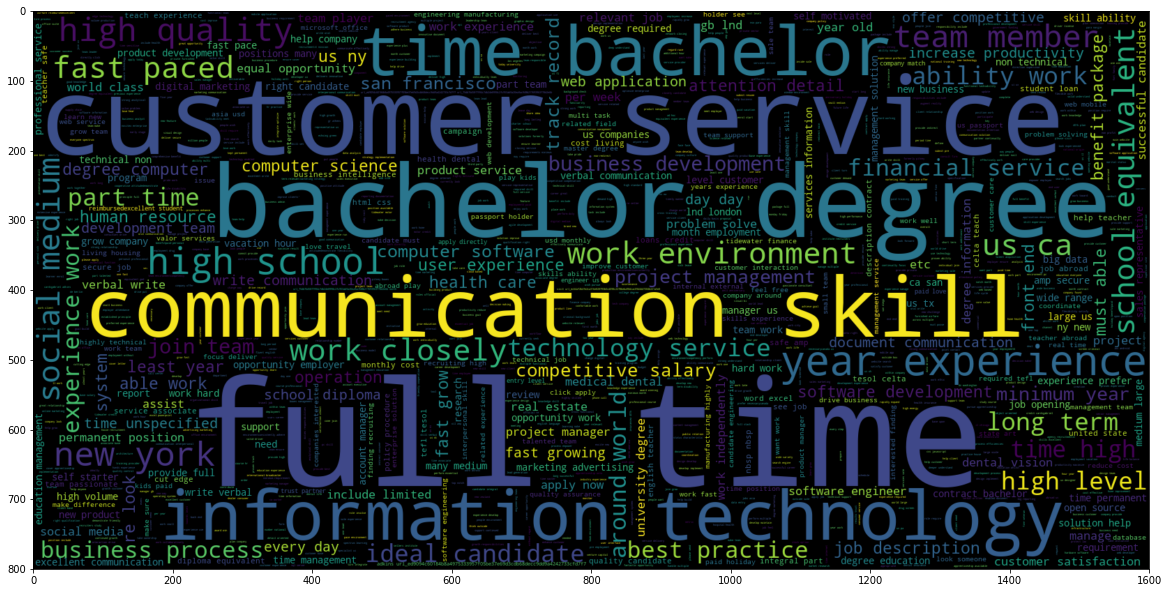

In [12]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

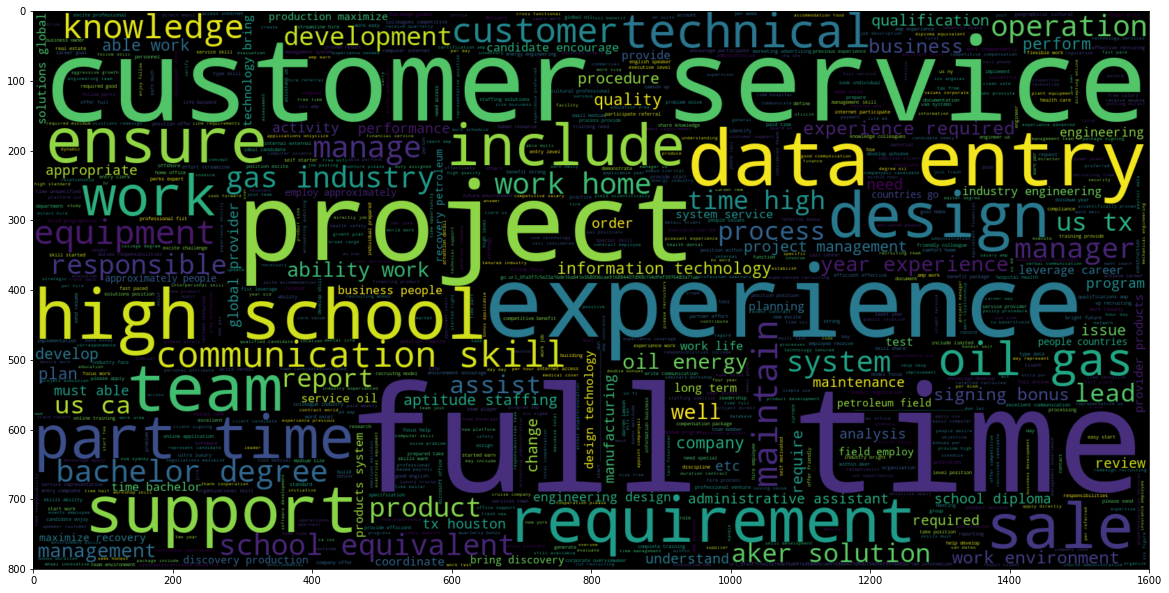

In [13]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
train_text , test_text ,train_category , test_category = train_test_split(df.text,df.fraudulent , test_size = 0.2 , random_state = 0)

In [15]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(train_text)
#transformed test reviews
cv_test_reviews=cv.transform(test_text)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (14304, 1673092)
BOW_cv_test: (3576, 1673092)


In [16]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(train_text)
#transformed test reviews
tv_test_reviews=tv.transform(test_text)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (14304, 1673092)
Tfidf_test: (3576, 1673092)


In [17]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = cv_train_reviews.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               167309300 
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 167,315,896
Trainable params: 167,315,896
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(cv_train_reviews,train_category , epochs = 10)

Epoch 1/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.2249 - accuracy: 0.9500
Epoch 2/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0345 - accuracy: 0.9876
Epoch 3/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0137 - accuracy: 0.9973
Epoch 4/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0135 - accuracy: 0.9973
Epoch 5/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0135 - accuracy: 0.9973
Epoch 6/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0136 - accuracy: 0.9973
Epoch 7/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0136 - accuracy: 0.9973
Epoch 8/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0135 - accuracy: 0.9973
Epoch 9/10
14304/14304 [==============================] - 198s 14ms/step - loss: 0.0136 - accuracy: 0.9973
Epoch 10/10
14304/14304 [============

In [19]:
pred_cv = model.predict(cv_test_reviews)
pred_cv[:5]

array([[1.0032593e-11],
       [1.7376429e-09],
       [2.4450628e-09],
       [2.7718830e-16],
       [2.7424499e-12]], dtype=float32)

In [20]:
pred_cv = np.around(pred_cv , decimals = 0)
pred_cv[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [21]:
accuracy_score(pred_cv,test_category)

0.9759507829977628

In [22]:
cv_report = classification_report(test_category,pred_cv,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3423
           1       0.94      0.47      0.63       153

    accuracy                           0.98      3576
   macro avg       0.96      0.73      0.81      3576
weighted avg       0.98      0.98      0.97      3576



In [23]:
cm_cv = confusion_matrix(test_category,pred_cv)
cm_cv

array([[3418,    5],
       [  81,   72]])

In [24]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

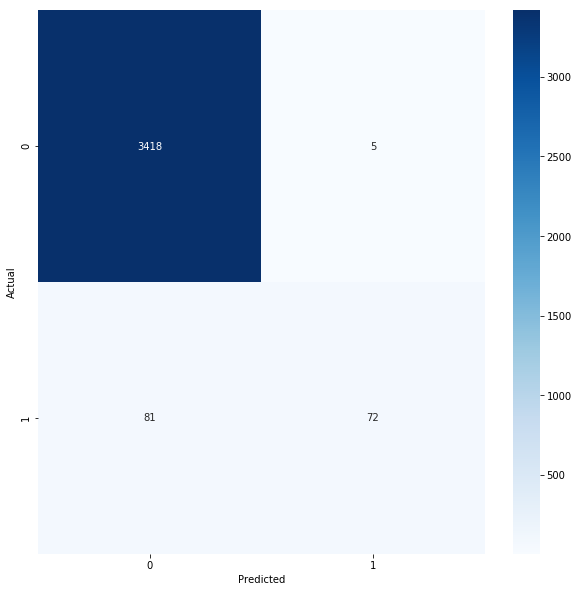

In [25]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')